In [2]:
#!jupyter nbconvert --to script pythiaTesting.ipynb
import sys
import ROOT as RT
import awkward as ak
from coffea.nanoevents import NanoEventsFactory, DelphesSchema
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import scipy.stats as ss

Welcome to JupyROOT 6.24/06


In [9]:
def getEvents(fileURL, treename):
    return NanoEventsFactory.from_root(fileURL, treepath = treename, schemaclass = DelphesSchema).events()

def histoSettings(histos):
    for key in histos:
        histos[key].Sumw2()
        histos[key].SetDirectory(0)


In [3]:
PIDof = {'LLP': 1500001}#, 'mu': 13, 'b': 5, 'K': 313}

filedir   = "root://cms-xrd-global.cern.ch//store/user/christiw/BDecay_delphes/v1/"
filenames = {'1e4mm': "m1_ct10000mm.root",
             '1e3mm': "m1_ct1000mm.root",
             '1e2mm': "m1_ct100mm.root",
             '1e1mm': "m1_ct10mm.root"}
treename  = "Delphes"

#datasets = {'1e4mm': getEvents(filedir+filenames['1e4mm'], treename)}

datasets = {}
for key in filenames:
    datasets[key] = getEvents(filedir + filenames[key], treename)


In [8]:
histos = {}
for key in PIDof:
    histos[key+'PT']  = RT.TH1F(key+'P_{T}', 'Events',30,0,100)
    histos[key+'Eta'] = RT.TH1F(key+'\eta', 'Events',30,0,5)
    histos[key+'Phi'] = RT.TH1F(key+'\phi', 'Events',30,-5,5)
    
#histoSettings(histos)

Help on CPPOverload in module cppyy:

Fill(...)
    int TH1::Fill(double x)
    int TH1::Fill(const char* name, double w)
    int TH1::Fill(double x, double w)



In [64]:
def inMuonChambers(event):
    
    llp = event.llp
    
    r = np.sqrt(llp.X**2 + llp.Y**2)
    
    CSCmask = ((abs(llp.Eta) < 2.4) &
               (abs(llp.Z) < 11000) & (abs(llp.Z) > 4000) &
               (r < 6955))

    
    DTmask  = ((abs(llp.Z)< 6610) &
               (r < 7380) & (r > 3800))
    
    nDT = ak.sum(ak.flatten(DTmask))
    nCSC = ak.sum(ak.flatten(CSCmask))
    
    return nCSC, nDT

In [65]:
inDT = {}
inCSC = {}
actualNllp = {}
for ctau in datasets:
    
    event = datasets[ctau]
    
    actualNllp[ctau] = ak.count(event.llp.X)
    
    nCSC, nDT = inMuonChambers(event)
    
    inDT[ctau] = nDT
    inCSC[ctau] = nCSC


In [83]:
DTacc = []
CSCacc = []
num = [1e1, 1e0, 1e-1, 1e-2]
for key in inDT:
    DTacc.append(inDT[key]/actualNllp[key])
    CSCacc.append(inCSC[key]/actualNllp[key])

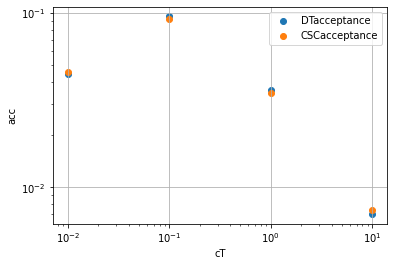

In [92]:
plt.scatter(num,DTacc, label = 'DTacceptance')
plt.scatter(num,CSCacc, label = 'CSCacceptance')
plt.grid()
plt.yscale('log')
plt.xscale('log')
plt.xlabel("cT")
plt.ylabel("acc")
plt.legend()

In [107]:
def countCSCclusters(event):
    tot = ak.count(ak.flatten(event.CscCluster130.NHits, axis=None))
    return tot

Text(0, 0.5, 'CSC cluster Eff.')

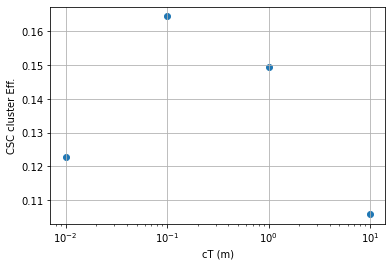

In [121]:
CSCclusters = []
CSCclusterEff = []
num = [1e1, 1e0, 1e-1, 1e-2]

for ctau in datasets:
    
    event = datasets[ctau]
    
    count = countCSCclusters(event)
    
    CSCclusters.append(count)
    
    CSCclusterEff.append(count/inCSC[ctau])

plt.scatter(num, CSCclusterEff)
plt.grid()
#plt.yscale('log')
plt.xscale('log')
plt.xlabel("cT (m)")
plt.ylabel("CSC cluster Eff.")
#plt.legend()

In [318]:
def cscPtAccDens(event, zmin, zmax, rmin, rmax, Emin, Emax):
    
    
    llp = event.llp
    cluster = event.CscCluster130
    
    
    rllp = np.sqrt(llp.X**2 + llp.Y**2) 
    rcluster = np.sqrt(cluster.X**2 + cluster.Y**2)
    
    CSCmask = ((abs(llp.Eta) < 2.4) &
               (abs(llp.Z) < zmax) & (abs(llp.Z) > zmin) &
               (rllp < rmax) & (rllp > rmin) &
               (llp.PT < Emax) & (llp.PT > Emin))

    CSCmask130 = ((abs(cluster.Eta) < 2.4) &
               (abs(cluster.Z) < zmax) & (abs(cluster.Z) > zmin) &
               (rcluster < rmax) & (rcluster > rmin) &
               (cluster.PT < Emax) & (cluster.PT > Emin))

               
            
    nRecon = ak.sum(ak.flatten(CSCmask130, axis=None))
    
    
    nRe = ak.sum(ak.flatten(CSCmask, axis=None))
    
    return nRecon, nRe

In [339]:
def cscPosAccDens(event, zmin, zmax, rmin, rmax):
    
    
    llp = event.llp
    cluster = event.CscCluster130
    
    
    rllp = np.sqrt(llp.X**2 + llp.Y**2) 
    rcluster = np.sqrt(cluster.X**2 + cluster.Y**2)
    
    real = ((abs(llp.Eta) < 2.4) &
               (abs(llp.Z) < zmax) & (abs(llp.Z) > zmin) &
               (rllp < rmax) & (rllp > rmin))

    recon = ((abs(cluster.Eta) < 2.4) &
               (abs(cluster.Z) < zmax) & (abs(cluster.Z) > zmin) &
               (rcluster < rmax) & (rcluster > rmin))
    
    #these are just truth values so I can get away with just summing the indexes
    nReal= ak.sum(ak.flatten(real, axis=None))
    nRecon = ak.sum(ak.flatten(recon, axis=None))
    

    if nReal == 0: 
        eff, std = 0, 0
    else:
        eff = nRecon/nReal
        
        stdReal = np.sqrt(nReal)
        stdRecon = np.sqrt(nRecon)
    
        std = eff*np.sqrt((stdReal/nReal)**2 + (stdRecon/nRecon)**2)
    
    return eff, std

/tmp/ipykernel_21565/3493486698.py:32: RuntimeWarning: invalid value encountered in double_scalars
  std = eff*np.sqrt((stdReal/nReal)**2 + (stdRecon/nRecon)**2)
/uscms/home/aaportel/nobackup/miniconda3/envs/main/lib/python3.9/site-packages/numpy/core/_methods.py:43: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/uscms/home/aaportel/nobackup/miniconda3/envs/main/lib/python3.9/site-packages/numpy/core/_methods.py:39: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)


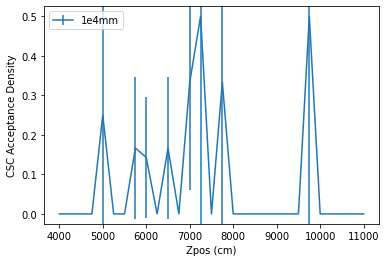

/tmp/ipykernel_21565/3493486698.py:32: RuntimeWarning: invalid value encountered in double_scalars
  std = eff*np.sqrt((stdReal/nReal)**2 + (stdRecon/nRecon)**2)


binSize: 250mm


/uscms/home/aaportel/nobackup/miniconda3/envs/main/lib/python3.9/site-packages/numpy/core/_methods.py:43: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/uscms/home/aaportel/nobackup/miniconda3/envs/main/lib/python3.9/site-packages/numpy/core/_methods.py:39: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)


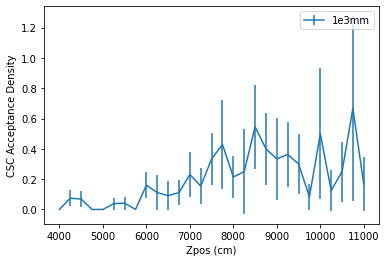

binSize: 250mm


/tmp/ipykernel_21565/3493486698.py:32: RuntimeWarning: invalid value encountered in double_scalars
  std = eff*np.sqrt((stdReal/nReal)**2 + (stdRecon/nRecon)**2)
/uscms/home/aaportel/nobackup/miniconda3/envs/main/lib/python3.9/site-packages/numpy/core/_methods.py:43: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/uscms/home/aaportel/nobackup/miniconda3/envs/main/lib/python3.9/site-packages/numpy/core/_methods.py:39: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)


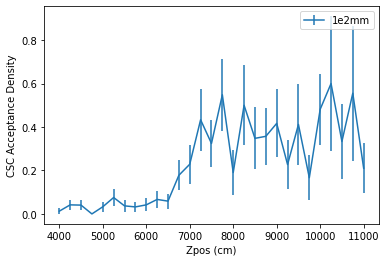

/tmp/ipykernel_21565/3493486698.py:32: RuntimeWarning: invalid value encountered in double_scalars
  std = eff*np.sqrt((stdReal/nReal)**2 + (stdRecon/nRecon)**2)


binSize: 250mm


/uscms/home/aaportel/nobackup/miniconda3/envs/main/lib/python3.9/site-packages/numpy/core/_methods.py:43: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/uscms/home/aaportel/nobackup/miniconda3/envs/main/lib/python3.9/site-packages/numpy/core/_methods.py:39: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)


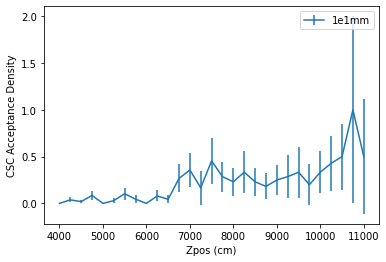

binSize: 250mm


In [344]:
zbinSize = 250

zstart = 4000
zstop = 11000 + int(zbinSize/2) + 1

rmin = 0
rmax = 6955

zrange = list(range(zstart, zstop , zbinSize))


for key in datasets:
    event = datasets[key]
    PosAccDensity = []
    PosAccDeviation = []
    for z in zrange:
        zmin = z - int(zbinSize/2)
        zmax = z + int(zbinSize/2)
        
        eff, std = cscPosAccDens(event, zmin, zmax, rmin, rmax)

        PosAccDensity.append(eff)
        PosAccDeviation.append(std)
        
    plt.errorbar(zrange, PosAccDensity, PosAccDeviation, label = key)
    

    plt.xlabel('Zpos (cm)')
    plt.ylabel('CSC Acceptance Density')
    #plt.title('ctau = 1e1mm')
    plt.legend()
    plt.show()
    print('binSize: ' + str(zbinSize) + 'mm')

In [325]:
len(datasets)


4

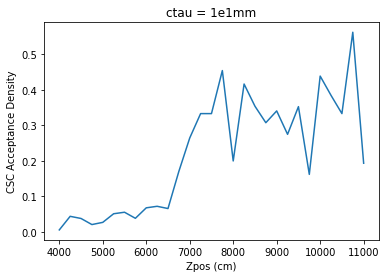

binSize: 250mm


In [316]:
zbinSize = 250

zstart = 4000
zstop = 11000 + int(zbinSize/2) + 1

rmin = 0
rmax = 6955

zrange = list(range(zstart, zstop , zbinSize))
PosAccDensity = []
for z in zrange:
    
    zmin = z - int(zbinSize/2)
    zmax = z + int(zbinSize/2)
    nRecon, nRe = 0, 0
    for key in datasets:
        event = datasets[key]
        tempRecon, tempRe = cscPosAccDens(event, zmin, zmax, rmin, rmax)
        nRecon += tempRecon
        nRe += tempRe
    
    '''event = datasets['1e1mm']
    tempRecon, tempRe = cscPosAccDens(event, zmin, zmax, rmin, rmax)
    nRecon += tempRecon
    nRe += tempRe'''
        
    PosAccDensity.append(nRecon/nRe)
    
plt.plot(zrange, PosAccDensity)
plt.xlabel('Zpos (cm)')
plt.ylabel('CSC Acceptance Density')
plt.title('ctau = 1e1mm')
plt.show()
print('binSize: ' + str(zbinSize) + 'mm')

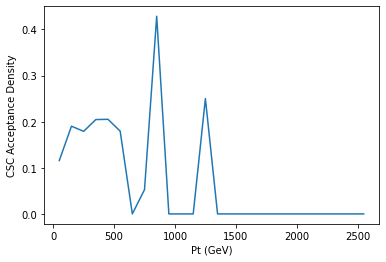

binSize: 100GeV


In [298]:
EbinSize = 100

Estart = 50
Estop = 2500 + int(EbinSize/2) + 1

zmin = 4000
zmax = 11000

rmin = 0
rmax = 6955

Erange = []
EAccDensity = []
for E in range(Estart, Estop , EbinSize):
    Erange.append(E)
    Emin = E - int(EbinSize/2)
    Emax = E + int(EbinSize/2)
    nRecon, nRe = 0, 0
    for key in datasets:
        event = datasets[key]
        tempRecon, tempRe = cscPtAccDens(event, zmin, zmax, rmin, rmax, Emin, Emax)
        if tempRe == 0:
            tempRecon = 0
            tempRe = 1
        nRecon += tempRecon
        nRe += tempRe
        
        
    EAccDensity.append(nRecon/nRe)
    
plt.plot(Erange, EAccDensity)
plt.xlabel('Pt (GeV)')
plt.ylabel('CSC Acceptance Density')
plt.show()
print('binSize: ' + str(EbinSize) + 'GeV')

In [292]:
ak.flatten(event.llp.PT > 0)

<Array [True, True, True, ... True, True, True] type='11436 * bool'>